In [83]:
# Basic tools
import pandas as pd
import numpy as np
import math
import datetime
from collections import Counter

# Web scraping and cleaning
import re
import json
import requests
from bs4 import BeautifulSoup

# Graph
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read csv files

In [3]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [5]:
df_user = pd.read_csv('takehome_user_engagement.csv')

# Set index to the datetime format

In [7]:
df_user['datetime'] = pd.to_datetime(df_user['time_stamp'])

In [11]:
df_user = df_user.set_index('datetime')

In [13]:
df_user = df_user.drop('time_stamp', axis=1)

# Generate our target (adopted users) from 'takehome_user_engagement.csv'

In [61]:
# a list for adopted users' user id
adoption =[]

for i in range(1, max(df_user['user_id'])+1):
    # A series with combined data weekly
    freq_group = df_user[df_user['user_id'] == i]['visited'].resample('W').sum()
    # check whether freq_group is empty
    if freq_group.empty == False:
        # find the max combined data
        max_freq = max(freq_group) 
    if max_freq > 2:
        adoption.append(i)

# Generate a new col for adopted users in 'takehome_users.csv'
1: adoption; 0: not adoption

In [71]:
df['adopted_user'] = 0

In [73]:
for i in range(len(df)):
    if df.loc[i, 'object_id'] in adoption:
        df.loc[i, 'adopted_user'] = 1

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [94]:
df.tail(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
11990,11991,2014-04-20 14:22:45,Vaughn Arthur,ArthurJVaughn@gmail.com,SIGNUP_GOOGLE_AUTH,1.401460e+09,0,0,388,NaN,0
11991,11992,2014-04-09 19:39:56,Hermansen Amanda,AmandaAHermansen@yahoo.com,PERSONAL_PROJECTS,1.397245e+09,0,0,129,NaN,0
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN,0
11993,11994,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaN,0,0,84,5450.0,0
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0,0,0,NaN,0
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN,0


# Categoricals

### Remove 'name' and 'email'

In [95]:
df = df.drop(['name', 'email'], axis=1)

### Generate 'year' and 'month' column from 'creation_time'

In [98]:
df['creation_time_year'] = pd.DatetimeIndex(df['creation_time']).year

In [102]:
# It only has 3 classes so I can dummify them later
Counter(df['creation_time_year'])

Counter({2014: 3527, 2013: 5676, 2012: 2797})

In [100]:
df['creation_time_month'] = pd.DatetimeIndex(df['creation_time']).month

In [106]:
# change months to 4 seasons
for i in range(len(df)):
    if df.loc[i, 'creation_time_month'] < 4:
        df.loc[i, 'creation_time_month'] = 'spring'
    elif 3 < df.loc[i, 'creation_time_month'] < 7:
        df.loc[i, 'creation_time_month'] = 'summer'
    elif 6 < df.loc[i, 'creation_time_month'] < 10:
        df.loc[i, 'creation_time_month'] = 'fall'
    else:
        df.loc[i, 'creation_time_month'] = 'winter'

In [109]:
# remove 'creation_time'
df = df.drop('creation_time', axis=1)

### OneHotEncoding: 'creation_source', 'creation_time_year', 'creation_time_month'

In [111]:
df = pd.get_dummies(df, columns=['creation_source', 'creation_time_year', 'creation_time_month'], drop_first=True)

# Numericals

### last_session_creation_time

In [117]:
for i in range(len(df)):
    df.loc[i, 'last_session_creation_time'] = pd.to_datetime(df.loc[i, 'last_session_creation_time'], unit='s')

In [120]:
df['last_session_creation_time_month'] = pd.DatetimeIndex(df['last_session_creation_time']).month

In [121]:
# change months to 4 seasons
for i in range(len(df)):
    if df.loc[i, 'last_session_creation_time_month'] < 4:
        df.loc[i, 'last_session_creation_time_month'] = 'spring'
    elif 3 < df.loc[i, 'last_session_creation_time_month'] < 7:
        df.loc[i, 'last_session_creation_time_month'] = 'summer'
    elif 6 < df.loc[i, 'last_session_creation_time_month'] < 10:
        df.loc[i, 'last_session_creation_time_month'] = 'fall'
    else:
        df.loc[i, 'last_session_creation_time_month'] = 'winter'

### invited_by_user_id

In [125]:
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

In [127]:
for i in range(len(df)):
    if df.loc[i, 'invited_by_user_id'] > 0:
        df.loc[i, 'invited_by_user_id'] = 1

### org_id

In [135]:
org_common = dict(Counter(df['org_id']).most_common())

In [137]:
df['org_id'] = df['org_id'].map(org_common)

In [144]:
df['org_id'] = pd.cut(df['org_id'], 3, labels=['low', 'median', 'high'])

### object_id

In [176]:
df = df.drop('object_id', axis=1)

### OneHotEncoding: 'last_session_creation_time_month', 'org_id'

In [146]:
df = pd.get_dummies(df, columns=['last_session_creation_time_month', 'org_id'], drop_first=True)

# Review 

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
opted_in_to_mailing_list                   12000 non-null int64
enabled_for_marketing_drip                 12000 non-null int64
invited_by_user_id                         12000 non-null float64
adopted_user                               12000 non-null int64
creation_source_ORG_INVITE                 12000 non-null uint8
creation_source_PERSONAL_PROJECTS          12000 non-null uint8
creation_source_SIGNUP                     12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH         12000 non-null uint8
creation_time_year_2013                    12000 non-null uint8
creation_time_year_2014                    12000 non-null uint8
creation_time_month_spring                 12000 non-null uint8
creation_time_month_summer                 12000 non-null uint8
creation_time_month_winter                 12000 non-null uint8
last_session_creation_time_month_spring    12000 non-null

In [178]:
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_time_year_2013,creation_time_year_2014,creation_time_month_spring,creation_time_month_summer,creation_time_month_winter,last_session_creation_time_month_spring,last_session_creation_time_month_summer,last_session_creation_time_month_winter,org_id_median,org_id_high
0,1,0,1.0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,0,0,1.0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1
2,0,0,1.0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
3,0,0,1.0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1
4,0,0,1.0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0


# Preprocessing of imbalanced labels

In [89]:
# imbalanced labels
Counter(df['adopted_user'])

Counter({0: 10005, 1: 1995})

In [179]:
adopt_yes = df[df['adopted_user'] == 1]

In [180]:
len(adopt_yes)

1995

In [181]:
len(df[df['adopted_user'] == 0])

10005

In [155]:
# get 1995 index randomly  
index_1995 = np.random.randint(len(df[df['adopted_user'] == 0]), size=1995)

In [182]:
# use index to select rows
adopt_no = df.iloc[index_1995.tolist(), ]

In [183]:
df_balanced = pd.concat([adopt_no, adopt_yes])

In [184]:
df_balanced.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_time_year_2013,creation_time_year_2014,creation_time_month_spring,creation_time_month_summer,creation_time_month_winter,last_session_creation_time_month_spring,last_session_creation_time_month_summer,last_session_creation_time_month_winter,org_id_median,org_id_high
9282,1,0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4459,1,0,0.0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1
4862,0,0,0.0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0
1989,0,0,1.0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0
5447,0,0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


# Train/test data split

In [185]:
X = df_balanced.drop('adopted_user', axis=1)
y = df_balanced['adopted_user']

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [187]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


# Feature importance

In [188]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
forest.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [189]:
# get importances of each feature
importances = forest.feature_importances_

# get feature name of each column
feat_labels = X_train.columns

# arrange the order of importances from larget to small and extract its index
indices = np.argsort(importances)[::-1]

Text(0.5, 1.0, 'Feature importance derived from Randomforest')

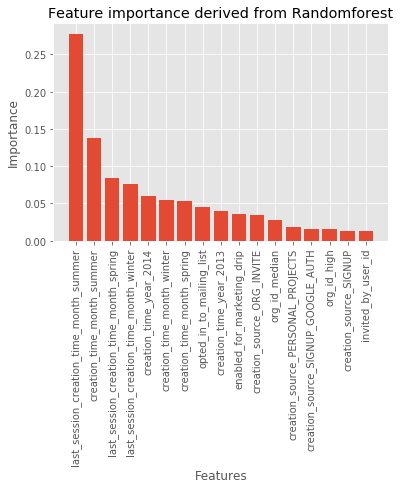

In [190]:
plt.style.use('ggplot')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance derived from Randomforest')

# Model

In [191]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=100, random_state=1, solver='lbfgs')
# train the model
logit.fit(X_train_std, y_train)

# predict and check the accuracy
y_pred = logit.predict(X_test_std)

from sklearn.metrics import accuracy_score
print('The accuracy of logistc regression with C=100 is {}'.format(accuracy_score(y_test, y_pred)))

The accuracy of logistc regression with C=100 is 0.7251461988304093


Text(0.5, 1.0, 'ROC Curve (Logistic regression)')

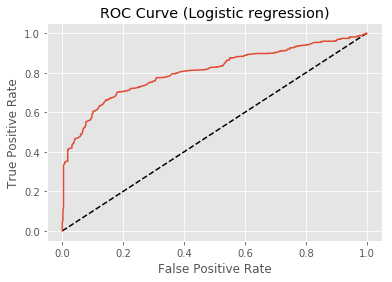

In [192]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic regression)')

### KNN

In [193]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [194]:
print ('The accuracy of KNN is {}'.format(accuracy_score(y_test, knn.predict(X_test_std))))

The accuracy of KNN is 0.758563074352548


Text(0.5, 1.0, 'ROC Curve (KNN)')

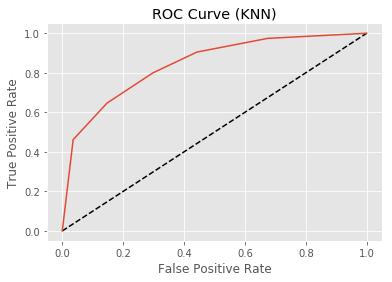

In [195]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')

### Gradient boosting

In [196]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt=GradientBoostingClassifier(random_state=1, n_estimators=100)
gbrt.fit(X_train_std, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [197]:
print('The accuracy of Gradient boosting with n_estimators=100 is {}'.format(gbrt.score(X_test_std, y_test)))

The accuracy of Gradient boosting with n_estimators=100 is 0.7694235588972431


Text(0.5, 1.0, 'ROC Curve (Gradient boosting)')

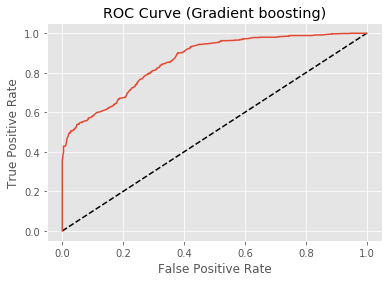

In [198]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = gbrt.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient boosting)')

### Random forest

In [199]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
forest.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [200]:
print('The accuracy of Randomforest with n_estimators=25 and gini is {}'.format(accuracy_score(y_test, forest.predict(X_test_std))))

The accuracy of Randomforest with n_estimators=25 and gini is 0.7694235588972431


Text(0.5, 1.0, 'ROC Curve (Randomforest)')

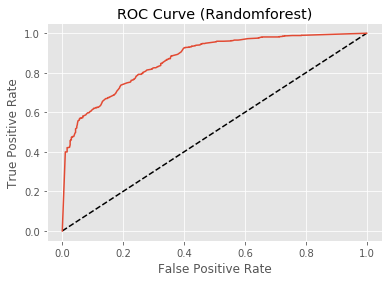

In [201]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Randomforest)')

# Randomized search with cross validation

In [202]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [203]:
forest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_std, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [204]:
best = rf_random.best_params_
print ('The best parametmers are {} and the accuracy is {}'.format(best, accuracy_score(y_test, rf_random.predict(X_test_std))))

The best parametmers are {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False} and the accuracy is 0.7752715121136173


# Grid search with cross validation by using previous parameters

In [207]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50, 60, 70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [600, 700, 800, 900, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [208]:
grid_search.fit(X_train_std, y_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50, 60, 70], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'n_estimators': [600, 700, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [209]:
print ('The best parametmers are {} and the accuracy is {}'.format(grid_search.best_params_, accuracy_score(y_test, grid_search.predict(X_test_std))))

The best parametmers are {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 600} and the accuracy is 0.7752715121136173


# Summary

From the feature importancereport, last_session_creation_time and creation_time are both important for predicting future user adoption. It is also indicating how to create their accounts (createion_source) is not so important. Summer is another indicator of prediction when I generate seasonal features from last_session_creation_time and creation_time columns. I would recommend that the company could prepare some special events and discounts for future users in summer, particularly. The randomforest model shows the best accuracy (77%) among logistic regression, KNN, and gradient boosting. 

THe final notes foe these datasets are that there are a lot of personal information instead of useful information for modeling. 